<center>
<h1 style="font-family:verdana">
 💻 🧑 Classificació d'intencions 🧑 💻


### MIDA DELS EMBEDDINGS
Experimentació sobre la mida ideal dels embeddings. S'avaluen múltiples mides d'embeddings (embedding_dims = [50, 100, 200, 300, 500]) per observar-ne l'impacte en la precisió. El model s'entrena i s'avalua per a cada dimensió, recopilant els valors de precisió per a la validació i el conjunt de prova, cosa que permet comparar com afecta cada mida el rendiment.

---

<h2> Índex </h2>

1. [Inspecció del conjunt de dades](#section-one)
  * [Exercici 1](#ex-one)
2. [Preprocessament de dades](#section-two)
  * [Exercici 2](#ex-two)
  * [Exercici 3](#ex-three)
3. [Disseny del model i entrenament](#section-three)
  * [Exercici 4](#ex-four)
  * [Exercici 5](#ex-five)
4. [Lliurable](#section-four)
---

In [28]:
import random
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, MaxPooling1D, GlobalMaxPooling1D, Dropout, Conv1D, GlobalAveragePooling1D, LayerNormalization #Remove
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

# Descargamos los recursos necesarios para la lematización
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to C:\Users\Lola Monroy
[nltk_data]     Mir\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Lola Monroy
[nltk_data]     Mir\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [29]:
!pip install gdown
!gdown "https://drive.google.com/uc?id=1u2wzXvsuscLeFHwXcDwMDaNDy0u_99-t"
!tar -zxf nlu_ATIS_data.tar.gz


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


"gdown" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


<h1><a name="section-one"> 1. Inspecció del conjunt de dades </a></h1>

A la carpeta `data` tenim els diferents fitxers CSV que utilitzarem per a aquesta pràctica.

En primer lloc, llegirem les dades dels fitxers CSV amb `pandas`.

In [30]:
train_data = pd.read_csv('./data/train.csv', header=None) # la última columna té la intenció de cada frase (1a columna)
val_data = train_data.tail(900) # Partim una part del train per tenir validation partition
train_data = pd.read_csv('./data/train.csv', header=None, nrows=4078)
test_data = pd.read_csv('./data/test.csv', header=None)

print('Training size:', len(train_data))
print('Validation dataset size:', len(val_data))
print('Test dataset size:', len(test_data))

Training size: 4078
Validation dataset size: 900
Test dataset size: 893


In [31]:
random_number = random.randint(0, len(train_data)-1)

train_sentences = list(train_data[0]) # primera columna del dataset, té la frase del usuari
train_labels = list(s.replace('"', '') for s in train_data[2]) 
train_labels = list(s.replace(' ', '') for s in train_labels)

print('Sentence: ', train_sentences[random_number])
print('Intent: ', train_labels[random_number])

Sentence:  does american airlines fly from philadelphia to dallas
Intent:  flight


In [32]:
num_labels = 0  # Les labels son les possibles intencions del usuari
for label in set(train_labels):
  print(f'Label {num_labels}:', label.split('.')[-1])
  num_labels += 1

print(f'\nThere are a total of {num_labels} intent labels') # Classes que haurem de predir segons la intenció

Label 0: airport
Label 1: airfare
Label 2: airline
Label 3: ground_service+ground_fare
Label 4: ground_fare
Label 5: quantity
Label 6: meal
Label 7: flight+airfare
Label 8: restriction
Label 9: aircraft+flight+flight_no
Label 10: airline+flight_no
Label 11: aircraft
Label 12: city
Label 13: flight_no
Label 14: flight
Label 15: capacity
Label 16: cheapest
Label 17: flight_time
Label 18: ground_service
Label 19: distance
Label 20: abbreviation
Label 21: airfare+flight_time

There are a total of 22 intent labels


<h1><a name="section-two"> 2. Preprocessament de dades </a></h1>

En primer lloc, haurem de tokenitzar les oracions. Això consisteix a convertir el text en representacions numèriques, ja que els models esperen unitats discretes.

En aquesta pràctica farem servir una tokenització senzilla, simplement dividirem les oracions en paraules i crearem un vocabulari basat en les paraules úniques de les dades d'entrenament. Cada paraula (token) tindrà assignat un ID únic.

Vegem com queda el vocabulari.

In [33]:
num_words=1000 # MOD

In [34]:
# Convertimos todas las frases a minúsculas
train_sentences_lower = [sentence.lower() for sentence in train_sentences]  # MOD

In [35]:

tokenizer = Tokenizer(num_words) 
tokenizer.fit_on_texts(train_sentences)


# Tokenitzem perquè cal codificar en int les paraules
vocab = tokenizer.word_index
print(vocab)  # Ens queden les consultes del usuari tokenitzades així podem utilitzar els tokens per buscar INTENT

{'to': 1, 'from': 2, 'flights': 3, 'the': 4, 'on': 5, 'what': 6, 'me': 7, 'flight': 8, 'boston': 9, 'show': 10, 'san': 11, 'i': 12, 'denver': 13, 'a': 14, 'francisco': 15, 'in': 16, 'and': 17, 'atlanta': 18, 'pittsburgh': 19, 'is': 20, 'dallas': 21, 'baltimore': 22, 'all': 23, 'philadelphia': 24, 'like': 25, 'are': 26, 'list': 27, 'airlines': 28, 'of': 29, 'between': 30, 'that': 31, 'washington': 32, 'leaving': 33, 'please': 34, 'pm': 35, 'morning': 36, 'would': 37, 'fly': 38, 'for': 39, 'fare': 40, 'first': 41, 'wednesday': 42, 'after': 43, 'there': 44, 'oakland': 45, "'d": 46, 'ground': 47, 'you': 48, 'does': 49, 'trip': 50, 'transportation': 51, 'class': 52, 'arriving': 53, 'cheapest': 54, 'need': 55, 'city': 56, 'round': 57, 'with': 58, 'before': 59, 'which': 60, 'available': 61, 'have': 62, 'give': 63, 'at': 64, 'fares': 65, 'american': 66, 'afternoon': 67, 'one': 68, 'want': 69, 'how': 70, 'way': 71, 'new': 72, 'dc': 73, 'nonstop': 74, 'arrive': 75, 'earliest': 76, 'york': 77, 'g

In [36]:
stemmer = PorterStemmer()
stemmed_vocab = [stemmer.stem(word) for word in vocab]
vocab = stemmed_vocab

---

 <h1><a name="ex-one"><center> ✏ Exercici 1 ✏</a></h1>

En aquest primer exercici us demanem que donat el vocabulari anterior convertiu la llista d'oracions de la partició d'entrenament, és a dir, `train_sentenes` en seqüències d'IDs.

Podeu trobar la documentació [aquí](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer).

In [38]:
#TODO

train_sequences = tokenizer.texts_to_sequences(train_sentences)
print(train_sentences[0])
print(train_sequences[0])

i want to fly from boston at 838 am and arrive in denver at 1110 in the morning
[12, 69, 1, 38, 2, 9, 64, 415, 84, 17, 75, 16, 13, 64, 493, 16, 4, 36]


Si ho heu fet correctament hauríeu d'obtenir això:

```
print(train_sentences[0])
print(train_sequences[0])

i want to fly from boston at 838 am and arrive in denver at 1110 in the morning
[12, 69, 1, 38, 2, 9, 64, 415, 84, 17, 75, 16, 13, 64, 493, 16, 4, 36]
```



---
A continuació haurem d'aconseguir que totes les seqüències tinguen una longitud fixa. Per a fer això primer fixarem la longitud segons la longitud màxima trobada a les seqüències del conjunt d'entrenament. I a continuació omplirem (*pad*) les seqüències que tinguen una longitud menor.


In [39]:
max_sequence_length = max(map(len, train_sequences))
train_pad_sequences = pad_sequences(train_sequences, maxlen=max_sequence_length)
print('Padded sequence: ', train_pad_sequences[0]) 
# D'aquesta manera assegurem que totes les sequencies siguin iguals posant padding --> APORTA SOROLL
# La millor manera de reduir el soroll es tenirlo darrere en comptes de davant

Padded sequence:  [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0  12  69   1  38   2   9  64 415
  84  17  75  16  13  64 493  16   4  36]


---

 <h1><a name="ex-two"><center> ✏ Exercici 2 ✏</a></h1>

Com l'ordre de les paraules sí que importa als models que utilitzarem en aquesta pràctica, és aconsellable que el *padding* estiga al final i no al principi. Busqueu [aquí](https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences) com fer perquè el codi anterior afegisca els zeros al final i no al principi de la seqüència.

In [40]:
#TODO
train_pad_sequences = pad_sequences(train_sequences, maxlen=max_sequence_length, padding='post')
print('Padded sequence: ', train_pad_sequences[0]) 

Padded sequence:  [ 12  69   1  38   2   9  64 415  84  17  75  16  13  64 493  16   4  36
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]


---

A continuació convertirem les classes d'intencions categòriques (*capacity*, *ground_service*, *flight*, etc.) en el que anomenem one-hot vector encoding. Aquesta tècnica s'utilitza per representar les dades categòriques com a vectors binaris. On cada vector representa una classe específica i l'element corresponent a la classe es posa a 1 i la resta d'elements es mantenen a 0.

Imaginem que tenim tres classes: *capacity*, *ground_service*, *flight*. Podríem codificar aquestes classes amb un vector únic de la forma següent:


```
   capacity -> [1, 0, 0]
   ground_service -> [0, 1, 0]
   flight -> [0, 0, 1]
```

Per aconseguir això primer codificarem les classes d'intenció en etiquetes numèriques.

In [41]:
label_encoder = LabelEncoder()
train_numerical_labels = label_encoder.fit_transform(train_labels)

# Estem fent One-hot encoding dels labels osigui de les intencions que l'usuari pot tenir
print(f'Original labels: {train_labels}\n')
print(f'Encoded labels: {train_numerical_labels} \n')

Original labels: ['flight', 'flight', 'flight_time', 'airfare', 'airfare', 'flight', 'aircraft', 'flight', 'flight', 'ground_service', 'flight', 'flight', 'airport', 'flight', 'flight', 'airfare', 'ground_service', 'flight', 'flight', 'flight', 'flight', 'flight', 'flight', 'aircraft', 'airfare', 'flight', 'airline', 'flight', 'ground_service', 'flight', 'airfare', 'flight', 'flight', 'flight', 'flight', 'airfare', 'airline', 'flight', 'flight', 'flight', 'distance', 'flight', 'airline', 'airline', 'flight', 'airline', 'ground_service', 'abbreviation', 'flight', 'flight', 'flight_time', 'flight', 'flight', 'ground_fare', 'flight', 'abbreviation', 'flight', 'flight', 'flight', 'flight', 'flight', 'airline', 'flight', 'ground_service', 'airline', 'flight', 'flight', 'airport', 'flight', 'flight', 'abbreviation', 'flight', 'flight', 'flight', 'flight', 'aircraft', 'airfare', 'flight', 'flight', 'flight', 'flight', 'flight', 'flight', 'flight', 'airline', 'flight', 'flight', 'flight', 'fli

I a continuació convertim les etiquetes a vectors one-hot:

In [42]:
num_classes = len(np.unique(train_numerical_labels))
train_encoded_labels = to_categorical(train_numerical_labels, num_classes)

print('Example: \n')
print(f'Original label: {train_labels[0]}\n')
print(f'Numerical label: {train_numerical_labels[0]}\n')
print(f'One-hot: {train_encoded_labels[0]}\n')

Example: 

Original label: flight

Numerical label: 12

One-hot: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]



---

 <h1><a name="ex-three"><center> ✏ Exercici 3 ✏</a></h1>

Amb la partició de validació i test haurem de realitzar els mateixos passos. Per tant, en aquest exercici us demanem que obtingueu `val_pad_sequences`, `val_encoded_labels`, `test_pad_sequences` i `test_encoded_labels`.

In [43]:
#TODO
val_sentences = list(val_data[0])
test_sentences = list(test_data[0])

val_sequences = tokenizer.texts_to_sequences(val_sentences)
test_sequences = tokenizer.texts_to_sequences(test_sentences)

val_pad_sequences = pad_sequences(val_sequences, maxlen=max_sequence_length, padding='post')
test_pad_sequences = pad_sequences(test_sequences, maxlen=max_sequence_length, padding='post')

In [44]:
val_labels = list(val_data[2])
val_labels = list(s.replace('"', '') for s in val_data[2]) 
val_labels = list(s.replace(' ', '') for s in val_labels)

test_labels = list(test_data[2])
test_labels = list(s.replace('"', '') for s in test_data[2]) 
test_labels = list(s.replace(' ', '') for s in test_labels)

In [45]:
def remove_values_and_indices(input_list, values_to_remove, other_list):
    indices_to_remove = [idx for idx, item in enumerate(input_list) if item in values_to_remove]
    cleaned_list = [item for item in input_list if item not in values_to_remove]
    cleaned_other_list = [item for idx, item in enumerate(other_list) if idx not in indices_to_remove]
    return cleaned_list, np.array(cleaned_other_list)

def remove_values_and_indices(input_list, values_to_remove, other_list):
    indices_to_remove = [idx for idx, item in enumerate(input_list) if item in values_to_remove]
    cleaned_list = [item for item in input_list if item not in values_to_remove]
    cleaned_other_list = [item for idx, item in enumerate(other_list) if idx not in indices_to_remove]
    return cleaned_list, np.array(cleaned_other_list)

values_to_remove = ['day_name','airfare+flight','flight+airline','flight_no+airline']
val_labels, val_pad_sequences = remove_values_and_indices(val_labels, values_to_remove, val_pad_sequences)
test_labels, test_pad_sequences = remove_values_and_indices(test_labels, values_to_remove, test_pad_sequences)

In [46]:
val_numerical_labels = label_encoder.transform(val_labels)
val_encoded_labels = to_categorical(val_numerical_labels, num_classes)

test_numerical_labels = label_encoder.transform(test_labels)
test_encoded_labels = to_categorical(test_numerical_labels, num_classes)

In [47]:
print('Example train: \n')
print(f'Original label: {val_labels[0]}\n')
print(f'Numerical label: {val_numerical_labels[0]}\n')
print(f'One-hot: {val_encoded_labels[0]}\n')

print('Example test: \n')
print(f'Original label: {test_labels[0]}\n')
print(f'Numerical label: {test_numerical_labels[0]}\n')
print(f'One-hot: {test_encoded_labels[0]}\n')

Example train: 

Original label: flight

Numerical label: 12

One-hot: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Example test: 

Original label: flight

Numerical label: 12

One-hot: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]



---

<h1><a name="section-three"> 3. Disseny del model i entrenament </a></h1>

En primer lloc, anem a comprovar si hi ha GPUs disponibles. A continuació si hi ha GPUs disponibles el codi assegurarà que *TensorFlow* només assigne memòria GPU quan siga necessari.

In [48]:
if tf.config.list_physical_devices('GPU'):
    print("GPU is available!")
else:
    print("GPU is not available. The model will be trained on CPU.")

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

GPU is not available. The model will be trained on CPU.


---

 <h1><a name="ex-five"><center> ✏ Exercici 5 ✏ </a></h1>

Modifiqueu els següents paràmetres del model anterior i analitzeu com afecten a la seva *accuracy*:

 1. **Preprocessament.** Modifiqueu el Tokenizer per canviar la mida del vostre vocabulari i afegiu nous passos de preprocessament. Alguns possibles canvis són canviar la mida del vocabulari, treure la capitalització o fer servir *lemmatització* o *stemming*.

 2. **Mida dels Embeddings.** Proveu diferents mides d'*Embeddings* i observeu com canvia l'*accuracy* del model. Heu d'explicar les vostres conclusions.

 3. **Xarxes Convolucionals.** Afegiu capes convolucionals al vostre model. Expliqueu amb detall els valors que heu provat i la vostra motivació a l'hora d'escollir-los. Recordeu, que també podeu provar diferents configuracions de *pooling*.

 4. **Xarxes Recurrents.**  Afegiu capes recurrents al vostre model (LSTM, GRU). Expliqueu amb detall els valors que heu provat i la vostra motivació.

 5. **Regularització.** Quan proveu configuracions amb més paràmetres veureu que el model comença a tenir *overfitting* molt prompte durant l'entrenament. Afegiu *Dropout* al vostre model. Heu d'explicar la vostra decisió de valors i de posició dins de la xarxa.

 6. **Balancejat de les classes.** Si analitzeu el dataset, veureu que la freqüència de les classes està molt desbalancejada. Keras us permet afegir un pes per a cada classe a l'hora de calcular la loss (Mireu el paràmetre "class_weigth" a la documentació https://keras.io/api/models/model_training_apis/). Calculeu un pes per a cada classe i afegiu-lo al mètode fit del vostre model.

 ---

In [52]:
##### 5.2. MIDA DELS EMBEDDINGS #################################################
# Busquem com afecta al accuracy canviar la mida dels embeddings (embedding_dim):

embedding_dims = [50, 100, 200, 300, 500] # La de 100 ja l'hem provat
vocab_size = num_words + 1  # AIXÒ POTSER HAURÀ DE CANVIAR AL PREPROCESSING

val_accuracies = []
test_accuracies = {}
histories = {}

for embedding_dim in embedding_dims:
    print(f"\nProvant amb la mida {embedding_dim}:\n")
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length)) # layer 1 - embedding 
    model.add(GlobalMaxPooling1D())  # layer 2 - pooling
    model.add(Dense(64, activation='relu'))  # layer 3 - relu
    model.add(Dense(num_classes, activation='softmax'))  # layer 4 - softmax

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    batch_size = 16
    epochs = 4

    History = model.fit(train_pad_sequences, train_encoded_labels, batch_size=batch_size, epochs=epochs, validation_data=(val_pad_sequences, val_encoded_labels))
    histories[embedding_dim] = History

    loss, test_accuracy = model.evaluate(test_pad_sequences, test_encoded_labels, batch_size=batch_size)
    val_accuracy = History.history['val_accuracy'][-1]  

    test_accuracies[embedding_dim] = test_accuracy
    val_accuracies.append(val_accuracy)

    print(f"\nVal accuracy amb la mida {embedding_dim}: {val_accuracy:.2f}")
    print(f"Test accuracy amb la mida {embedding_dim}: {test_accuracy:.2f}")



Provant amb la mida 50:

Epoch 1/4


c:\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


255/255 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7246 - loss: 1.7209 - val_accuracy: 0.7444 - val_loss: 0.8756
Epoch 2/4
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8084 - loss: 0.6998 - val_accuracy: 0.8478 - val_loss: 0.6364
Epoch 3/4
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8780 - loss: 0.5176 - val_accuracy: 0.8756 - val_loss: 0.4978
Epoch 4/4
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8979 - loss: 0.3835 - val_accuracy: 0.9022 - val_loss: 0.3897
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8920 - loss: 0.4474

Val accuracy amb la mida 50: 0.90
Test accuracy amb la mida 50: 0.87

Provant amb la mida 100:

Epoch 1/4
255/255 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6922 - loss: 1.6313 - val_accuracy: 0.8144 - val_loss: 0.7472
Epoch 2/4
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8539 - loss: 0.6105 - val_accuracy: 0.8900 - val_loss: 0.4686
Epoch 3/4
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9064 - loss: 

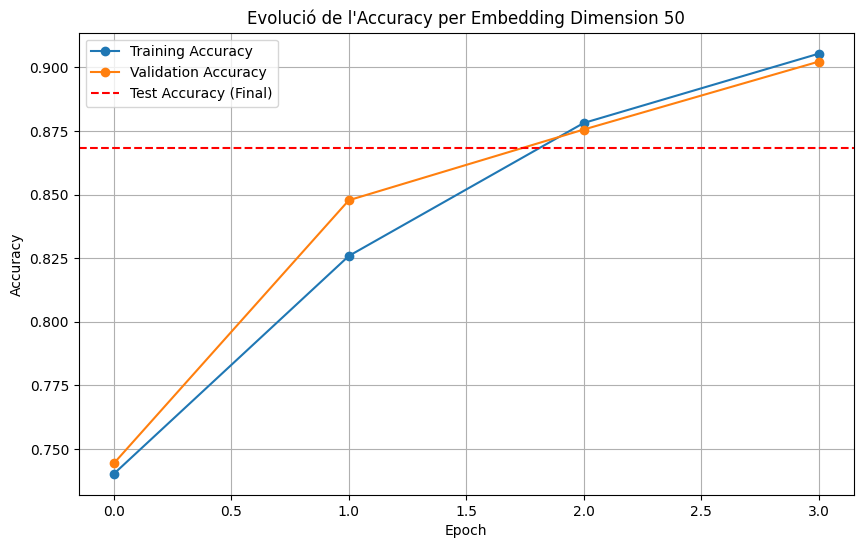

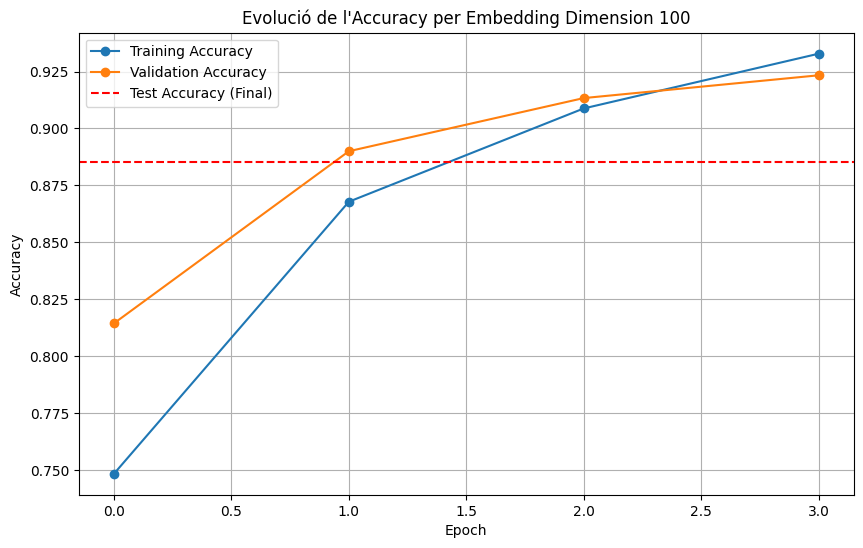

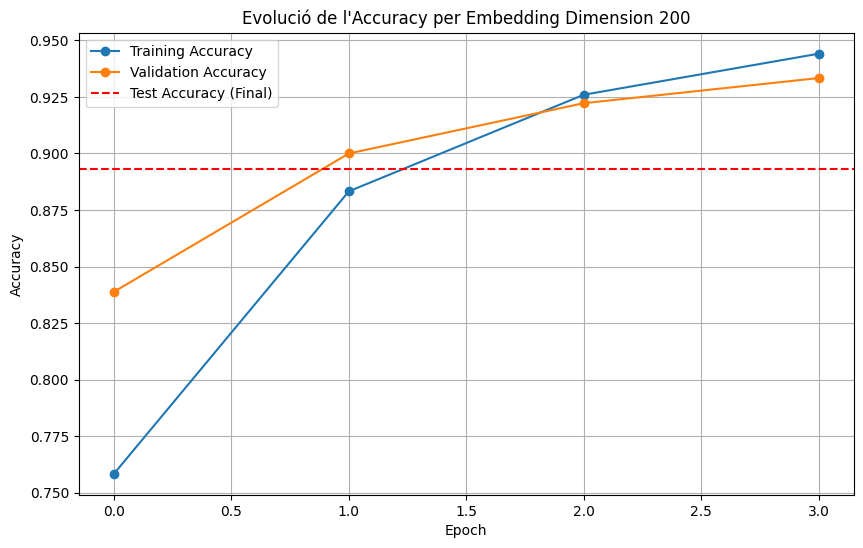

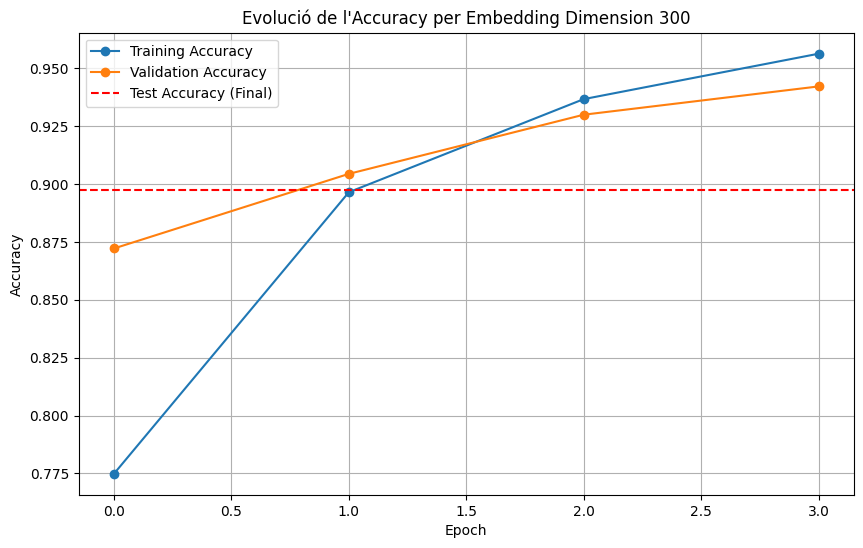

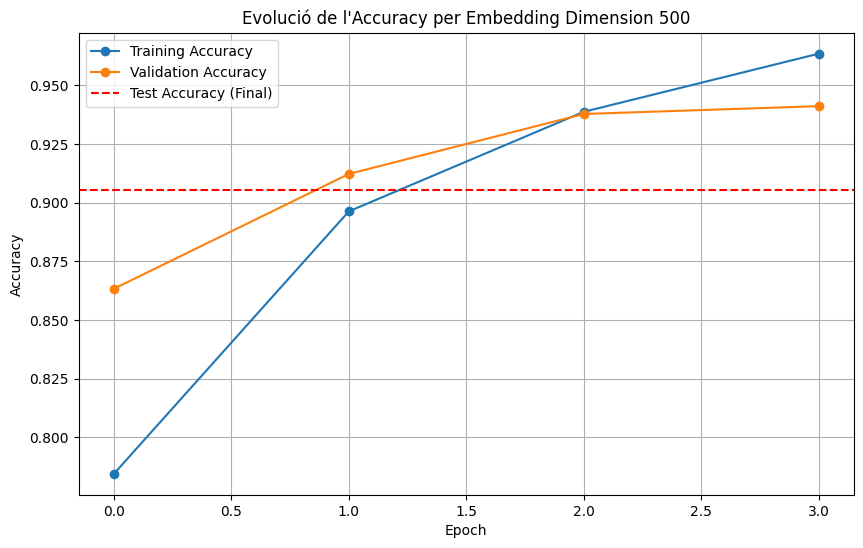

In [53]:
import matplotlib.pyplot as plt

for embedding_dim in embedding_dims: 
    plt.figure(figsize=(10, 6))
    plt.plot(histories[embedding_dim].history['accuracy'], marker='o', linestyle='-', label='Training Accuracy')
    plt.plot(histories[embedding_dim].history['val_accuracy'], marker='o', linestyle='-', label='Validation Accuracy')

    plt.axhline(y=test_accuracies[embedding_dim], color='r', linestyle='--', label='Test Accuracy (Final)')
    plt.title(f'Evolució de l\'Accuracy per Embedding Dimension {embedding_dim}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()



<h1><a name="section-four"> 4. Lliurable </a></h1>

Heu d'entregar un document PDF de com a **màxim 10 pàgines** que incloga els resultats de tots els exercicis així com una explicació de cadascun dels resultats i de la modificació que heu fet. L'estructura del document és:

1. Introducció.
2. Experiments i Resultats (amb raonament).
3. Conclusions.

No cal que afegiu el vostre codi al document, podeu entregar el *notebook* juntament amb el document.

 ---